In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib import ticker, cm

In [2]:
def get_fes(bins, val):
    F = []
    s = []
    kT = 1
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3328/3729066938.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  walls = plumed.read_as_pandas("data/walls.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3328/3729066938.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  MetaD = plumed.read_as_pandas("data/metad_data.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3328/3729066938.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")


(0, 20)

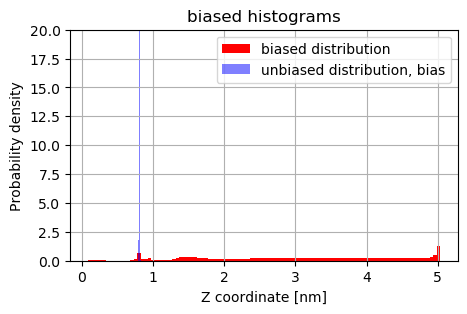

In [6]:
walls = plumed.read_as_pandas("data/walls.dat")
MetaD = plumed.read_as_pandas("data/metad_data.dat")
Funnel = plumed.read_as_pandas("data/Ca_EF2_funnel.dat")
plt.rcParams["figure.figsize"] = (5, 3)

MetaD_eq = MetaD.iloc[600000:]
walls_eq = walls.iloc[600000:]
Funnel_eq = Funnel.iloc[600000:]
merged_data = pd.merge(Funnel_eq, MetaD_eq, on="time")
merged_data = pd.merge(merged_data, walls_eq, on="time")
selected_columns = merged_data[['fps.lp', 'metad.rbias', 'uwall_rmsd.bias']]

val_bias, bins_bias, patches_bias = plt.hist(selected_columns["fps.lp"], bins=100, density=True, color='r', label="biased distribution")
kT = 1

w = [math.exp(selected_columns["metad.rbias"][i] + selected_columns["uwall_rmsd.bias"][i]) for i in range(len(selected_columns["fps.lp"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(selected_columns["fps.lp"], bins=500, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution, bias")
plt.grid()
plt.legend(loc="best")
plt.title("biased histograms")
plt.xlabel("Z coordinate [nm]")
plt.ylabel("Probability density")
plt.ylim([0, 20])

# Posso riportare anche questo plot, magari facendo uno zoom!

Text(0, 0.5, 'Free energy [kcal/mol]')

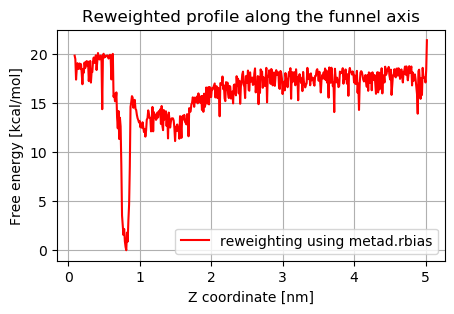

In [7]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)
plt.rcParams["figure.figsize"] = (5, 3)

plt.plot(dist, F/4.184, 'r',label="reweighting using metad.rbias")

with open('fes_fps.dat', 'w') as file:
    for item1, item2 in zip(dist, F):
        file.write(f"{item1}\t{item2/4.184}\n")  # Using tab as a separator

plt.grid()
plt.legend(loc="best")
plt.title("Reweighted profile along the funnel axis")
plt.xlabel("Z coordinate [nm]")
plt.ylabel("Free energy [kcal/mol]")

In [13]:

# find minimum value of fes
minf = min(F)
# plot fes
F0=0.0; F1=0.0; F_unbound=0.0; F2=0.0
for j in range(0, len(dist)):
    d = dist[j]
    # calculate probability
    p = math.exp((-F[j]+minf)/kT)
    # integrate in the two basins
    if(0.7<=d<=0.9): F0 += p
    if(3.50<d<=4.50): F_unbound += p
# calculate free energy difference and add to list. Correction funnel
R_cyl = 2
C_0 = 1/1660 
DeltaG = kT*math.log(F_unbound/F0) - 2.58*math.log(math.pi*R_cyl*R_cyl*C_0)
k_d = 0.12*1e-6
experiment = 2.57*math.log(k_d)
print("In silico: ", DeltaG/4.184, "       In vitro: ", experiment/4.184)

In silico:  -11.020775588254805        In vitro:  -9.788465445029258


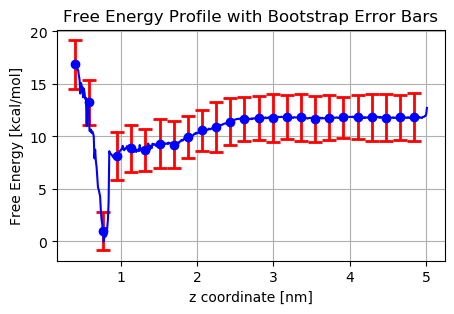

In [23]:
# Generate Bootstrap Samples
# Assuming you have n data points (distances and corresponding free energies), 
# you can create N bootstrap samples

# Number of bootstrap samples
N = 500

# Function to generate bootstrap samples
def generate_bootstrap_samples(data, N):
    n = len(data)
    bootstrap_samples = np.random.choice(data, (N, n), replace=True)
    return bootstrap_samples

bootstrap_samples = generate_bootstrap_samples(F/4.184, N)

# Calculate the standard deviation of the bootstrap samples
errors = np.std(bootstrap_samples, axis=0)

# Combine distance points, free energies, and errors for better visualization
free_energy_with_errors = list(zip(dist, F/4.184, errors))

step = 20
plt.rcParams["figure.figsize"] = (5, 3)
plt.errorbar(dist[::step], F[::step]/4.184, yerr=errors[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)
plt.plot(dist, F/4.184, 'b')
plt.title('Free Energy Profile with Bootstrap Error Bars')
plt.xlabel('z coordinate [nm]')
plt.ylabel('Free Energy [kcal/mol]')
plt.grid(True)
plt.show()

In [37]:
len(nblocks)

110